## Community Analysis

This notebook will summarize important attributes of a community from given building inventory and housing unit allocation information. This helps in understanding the data of the community avaiable on IN-CORE

In [83]:
## Importing all the modules from incore

import os
import pandas as pd
import geopandas as gpd
import contextily as ctx
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=12,10

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.cumulativebuildingdamage import CumulativeBuildingDamage
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingunitallocation import HousingUnitAllocation

from pyincore_viz.geoutil import GeoUtil as viz
data_service = DataService(client)
import warnings
warnings.filterwarnings('ignore')

In [86]:
client = IncoreClient()

Connection successful to IN-CORE services. pyIncore version detected: 0.9.0


### INPUT DATA

The building inventory information should be given in .csv format 
The housing unit allocatoin information given in .csv format

In [87]:
#Input data
bInv = pd.read_csv("Seaside_Building_Inventory_xy.csv") #Building Inventory Data
hua = pd.read_csv("IN-CORE_1cv1_housingunitallocation_1238.csv") #Housing Unit Allocation Data (The ouput file oh housing unit analysis)

###### Converting the data frame to gdf

In [88]:
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.geometry import Point
# Geodata frame requires geometry and CRS to be set
hua_gdf = gpd.GeoDataFrame(
    hua,
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(hua['x'], hua['y'])])
hua_gdf[['guid','x','y','numprec','geometry']].head(6)

,guid,x,y,numprec,geometry
0,e38d8575-7880-4a8c-b6d7-225ab1cf9264,-123.896065,46.012722,2.0,POINT (-123.89606 46.01272)
1,af5771b4-4f42-4166-b772-78a3706fa8ac,-123.903427,46.017498,1.0,POINT (-123.90343 46.01750)
2,37532fb5-5107-478b-ab2c-158eb001c68b,-123.903427,46.017498,4.0,POINT (-123.90343 46.01750)
3,66d39314-1c68-4634-a82c-8fcb37f529ff,-123.900246,46.013523,3.0,POINT (-123.90025 46.01352)
4,e519ec32-c5eb-422a-be3d-7ff4bb33f1e2,-123.898918,46.012257,2.0,POINT (-123.89892 46.01226)
5,0edcff97-8fa1-4558-b80e-610abe7b9f17,-123.898552,46.012253,7.0,POINT (-123.89855 46.01225)


In [89]:
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.geometry import Point
# Geodata frame requires geometry and CRS to be set
bldg_inv_gdf = gpd.GeoDataFrame(
    bInv,
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(bInv['x'], bInv['y'])])
bldg_inv_gdf[['guid','x','y','year_built','geometry']].head(6)

,guid,x,y,year_built,geometry
0,fba4c73f-9b1b-4942-b7fb-bc276a4e0a4e,-123.908997,46.014336,1968,POINT (-123.90900 46.01434)
1,65d6e370-c05b-4b2f-bd17-d914d1d056c7,-123.905846,45.997948,1992,POINT (-123.90585 45.99795)
2,dad76485-9694-409e-ac7f-c64c7bd5c32c,-123.908997,46.014336,1974,POINT (-123.90900 46.01434)
3,6f57cfb6-d244-40d5-96f5-03aeddd5e30a,-123.908997,46.014336,1984,POINT (-123.90900 46.01434)
4,929f1040-6224-409d-b4e3-58946daf3b91,-123.911827,45.997475,1964,POINT (-123.91183 45.99747)
5,9020fc6c-4b0e-4e5b-b8be-fa58141b57b5,-123.905846,45.997948,2007,POINT (-123.90585 45.99795)


In [90]:
bInv.columns
#important ones are appr_bldg, struct_typ, year_built
#should have unique guid 

Index(['Unnamed: 0', 'parid', 'parid_card', 'bldg_id', 'struct_typ',
       'str_prob', 'year_built', 'no_stories', 'a_stories', 'b_stories',
       'bsmt_type', 'sq_foot', 'gsq_foot', 'occ_type', 'occ_detail',
       'major_occ', 'broad_occ', 'appr_bldg', 'repl_cst', 'str_cst',
       'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val', 'efacility',
       'dwell_unit', 'str_typ2', 'occ_typ2', 'tract_id', 'guid', 'FID_NEW',
       'origin', 'stat_class', 'rmv_improv', 'rmv_land', 'elev', 'period',
       'strctid', 'x', 'y', 'value_matc', 'geometry'],
      dtype='object')

In [91]:
hua.columns
#important ones are race, hispan, gqtype

Index(['Unnamed: 0', 'addrptid', 'parid', 'parid_card', 'bldg_id',
       'struct_typ', 'str_prob', 'year_built', 'no_stories', 'a_stories',
       'b_stories', 'bsmt_type', 'sq_foot', 'gsq_foot', 'occ_type',
       'occ_detail', 'major_occ', 'broad_occ', 'appr_bldg', 'repl_cst',
       'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val', 'efacility',
       'dwell_unit', 'str_typ2', 'occ_typ2', 'tract_id', 'guid', 'FID_NEW',
       'origin', 'stat_class', 'rmv_improv', 'rmv_land', 'elev', 'period',
       'strctid', 'value_matc', 'blockid', 'huestimate', 'residential', 'x',
       'y', 'randomap', 'randommergeorder', 'blockidstr', 'huid', 'livetype',
       'numprec', 'ownershp', 'race', 'hispan', 'vacancy', 'gqtype', 'bgid',
       'randomhu', 'aphumerge', 'geometry', 'Race Ethnicity', 'Tenure Status'],
      dtype='object')

### Archtype

In [92]:
#present this table nicely - pivot table - Nathanael's notebook
bInv.struct_typ.value_counts()

W1    2444
RC    1504
W2     731
Name: struct_typ, dtype: int64

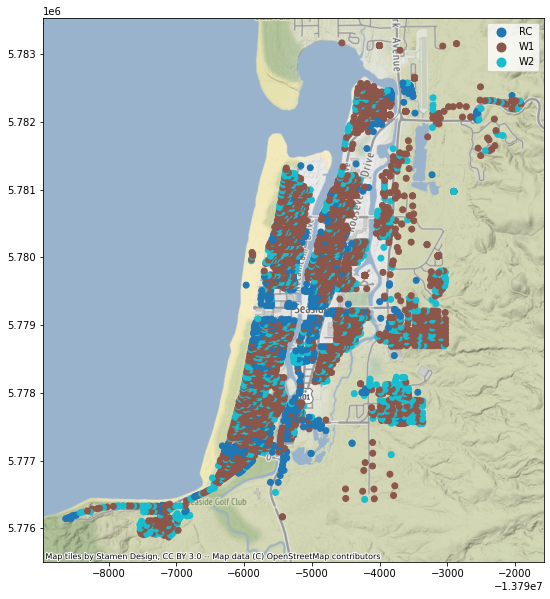

In [93]:
strct_typ_map = viz.plot_gdf_map(bldg_inv_gdf,column='struct_typ')
strct_typ_map


### Appraisal Value

<AxesSubplot:>

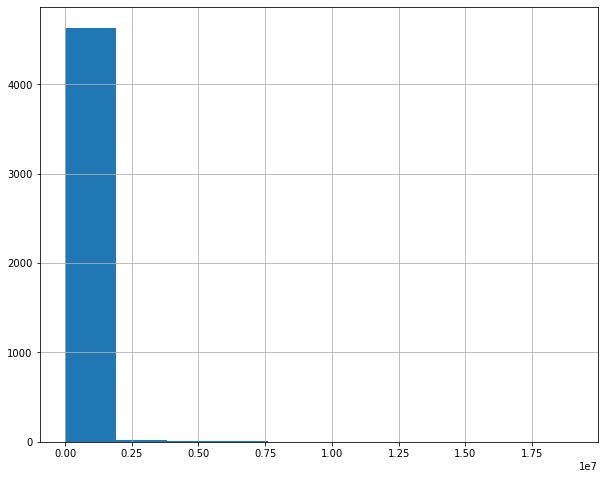

In [94]:
bInv.appr_bldg.hist()

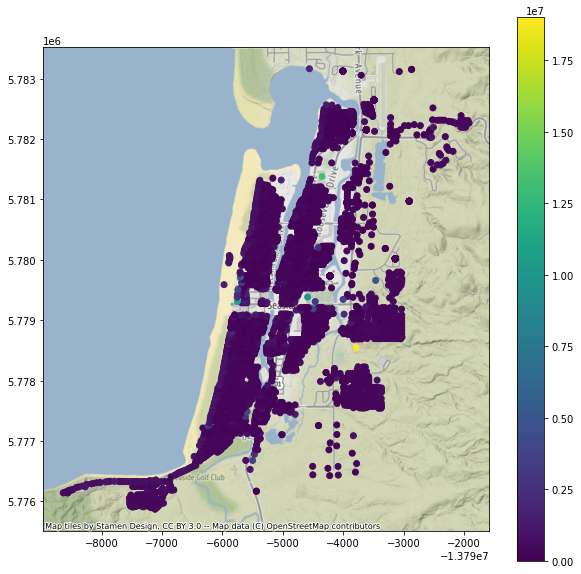

In [95]:
appr_bldg_map = viz.plot_gdf_map(bldg_inv_gdf,column='appr_bldg')
appr_bldg_map


### Building Age

<AxesSubplot:>

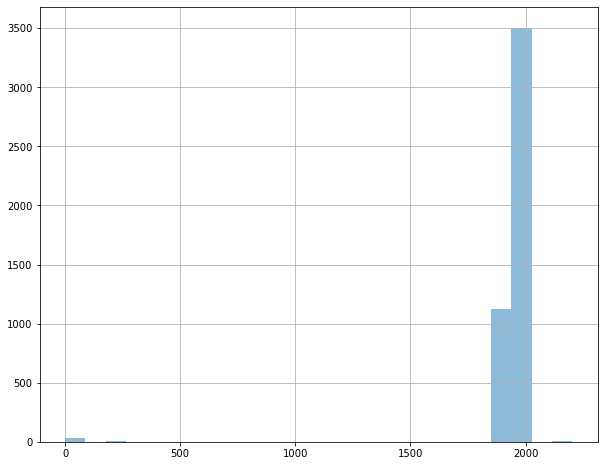

In [96]:
bInv.year_built.hist(bins=25, alpha = 0.5)

In [111]:
Retrofit = bInv["dgn_lvl"].value_counts()
print("Total Number of Buildings in the community for each Retrofit Level: \n", Retrofit)

Total Number of Buildings in the community for each Retrofit Level: 
 Pre - Code         2472
Moderate - Code     849
Low - Code          775
High - Code         583
Name: dgn_lvl, dtype: int64


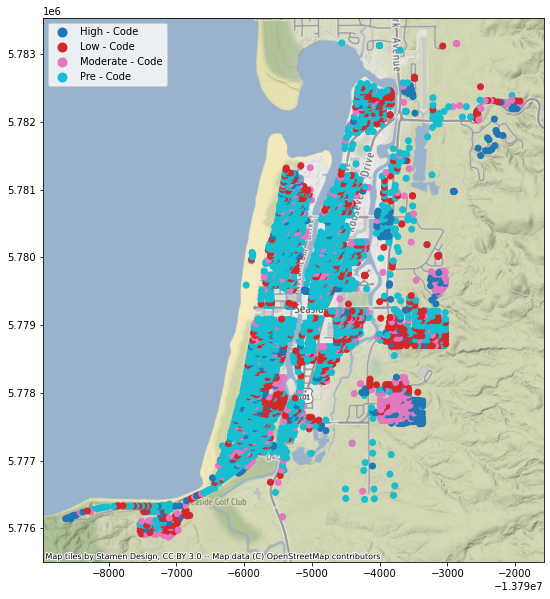

In [97]:
year_built_map = viz.plot_gdf_map(bldg_inv_gdf,column='dgn_lvl')
year_built_map

### Pivot Table for Year Built

### Race and Ethnicity

In [98]:
hua['Race Ethnicity'] = "0 Vacant HU No Race Ethnicity Data"
hua['Race Ethnicity'].notes = "Identify Race and Ethnicity Housing Unit Characteristics."

hua.loc[(hua['race'] == 1) & (hua['hispan'] == 0),'Race Ethnicity'] = "1 White alone, Not Hispanic"
hua.loc[(hua['race'] == 2) & (hua['hispan'] == 0),'Race Ethnicity'] = "2 Black alone, Not Hispanic"
hua.loc[(hua['race'].isin([3,4,5,6,7])) & (hua['hispan'] == 0),'Race Ethnicity'] = "3 Other Race, Not Hispanic"
hua.loc[(hua['hispan'] == 1),'Race Ethnicity'] = "4 Any Race, Hispanic"
hua.loc[(hua['gqtype'] >= 1),'Race Ethnicity'] = "5 Group Quarters no Race Ethnicity Data"

In [99]:
hua_re  = hua[["Race Ethnicity", "huestimate"]]
hua_re.dropna(inplace=True)

In [106]:
plt.rcParams["figure.figsize"]=12,12

In [100]:
hua_re

,Race Ethnicity,huestimate
0,"1 White alone, Not Hispanic",1.0
1,"1 White alone, Not Hispanic",1.0
2,"1 White alone, Not Hispanic",1.0
3,"1 White alone, Not Hispanic",1.0
4,"1 White alone, Not Hispanic",1.0
...,...,...
5983,0 Vacant HU No Race Ethnicity Data,18.0
5984,0 Vacant HU No Race Ethnicity Data,18.0
5985,0 Vacant HU No Race Ethnicity Data,2.0
5986,0 Vacant HU No Race Ethnicity Data,1.0


<AxesSubplot:ylabel='huestimate'>

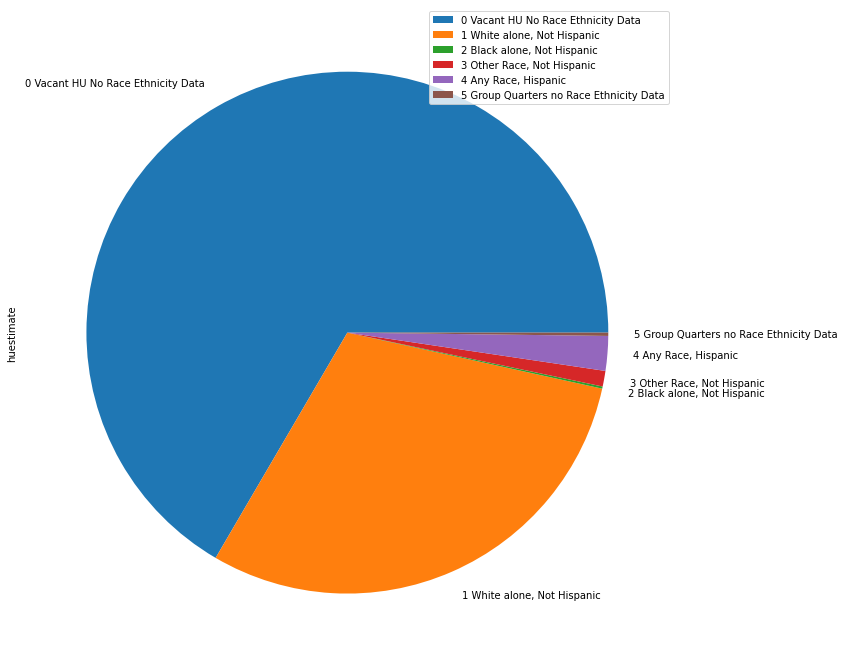

In [107]:
hua.groupby(['Race Ethnicity']).sum().plot(kind='pie', y='huestimate')

### Population Spread in the Community

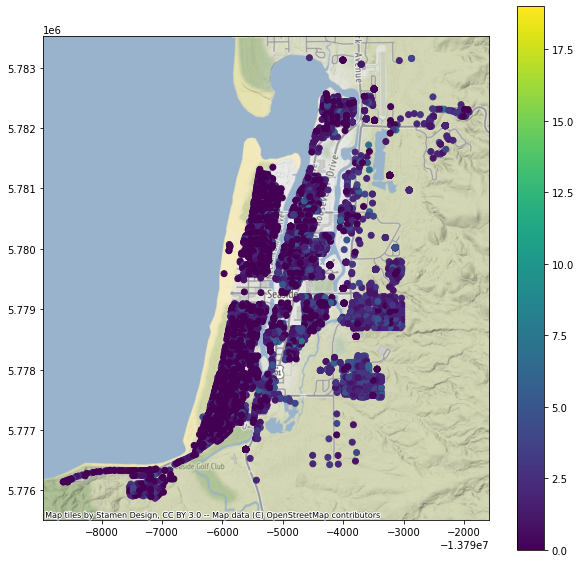

In [109]:
pop_map = viz.plot_gdf_map(hua_gdf,column='numprec')
pop_map